In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os 
import sys
from PropertyScraper.ml.query import get_house_full_features, get_price_history
from PropertyScraper.ml import Houston_zipcodes
sys.path.append("../")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [2]:
DATA_FOLDER = "../data/"
daily_scrpe_folder = DATA_FOLDER + "daily_har_scrape/combined_pickles/" 

In [4]:
YEAR = "%04d"%(2023)
MONTH = "%02d"%(4)
pickle_files = sorted([os.path.join(daily_scrpe_folder, f_) for f_ in os.listdir(daily_scrpe_folder)
               if "_for_sale.pkl" in f_ and f"_{YEAR}_{MONTH}_" in f_
               ])
monthly_df = pd.read_pickle(pickle_files[0])
criteria = monthly_df["status"].apply(lambda x: "under contract" in x.lower()) & \
           monthly_df["zipcode"].apply(lambda x: x in Houston_zipcodes)
monthly_df = monthly_df[criteria]
for pkl_file in tqdm(pickle_files[1:]):
    tem_df = pd.read_pickle(pkl_file)
    criteria = tem_df["status"].apply(lambda x: "under contract" in x.lower()) & \
               tem_df["zipcode"].apply(lambda x: x in Houston_zipcodes)
    tem_df = tem_df[criteria]
    monthly_df = monthly_df.append(tem_df).drop_duplicates(subset=["address"], keep="last")

monthly_df.head(3)

100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.48it/s]


,address,harlink,mp_features,agent,price,posted_days,status,zipcode,num_beds,num_bath,num_half_bath,building_sqft,has_loft,num_stories,num_parking_space
3,"9723 Old Timber Lane, Spring, TX 77379",https://www.har.com//homedetail/9723-old-timbe...,"2 bedrooms 1,896 Sqft. 2 full baths 3,885 lot ...",Carol Humerickhouse Texas United Realty,349000.0,5.0,Under Contract - P,77379,2.0,2.0,0.0,1896.0,0.0,0.0,0.0
51,"17206 Northchapel Street, Spring, TX 77379",https://www.har.com//homedetail/17206-northcha...,"3 bedrooms 1,485 Sqft. 2 full baths 8,085 lot ...",Tori Chase Executive Texas Realty,239500.0,6.0,Under Contract - P,77379,3.0,2.0,0.0,1485.0,0.0,0.0,0.0
52,"6726 River Mill Drive, Spring, TX 77379",https://www.har.com//homedetail/6726-river-mil...,"3 bedrooms 1,635 Sqft. 2 full baths 7,650 lot ...",Rosalinda Swartz Redfin Corporation,220000.0,25.0,Under Contract - P,77379,3.0,2.0,0.0,1635.0,0.0,0.0,0.0


In [5]:
len(monthly_df), len(tem_df), len(monthly_df.address)

(13731, 11542, 13731)

## Preprocessing

In [6]:
db_path = "../data/har_house_fullinfo/HouseFullInfo.db"
fullinfo_df = get_house_full_features(list(monthly_df.address), 
                        db_path=db_path)
fullinfo_df.head(3)

,address,sale_rent,mtime,High School Name,High Schoole stars,Mid Schoole stars,Mid School Name,Elementary Schoole stars,Elementary School Name,Bedrooms Num,Built Sqft from house features,Num Full Bath,Num Half Bath,Property Type,Zipcode,Garage Num,Lot Size m2,House age,Exterior Type,Floors:1,HOA Mandatory:,Monthly maintenance fee $,tax_rate_from_table,LON,LAT,Private Pool
154,"10109 Fernstone Lane, Houston, TX 77070",,1.680539e+09,Cypress Creek High School,4.0,4.0,Bleyl Middle School,3.0,Matzke Elementary School,NaN,NaN,NaN,NaN,nan,None,0.0,0.0,0,Others,,No,0.000000,2.754,-95.569709,29.952059,2
16772,"8743 Ute Creek Lane, Magnolia, TX 77354",,1.680539e+09,Magnolia High School,4.0,None,,4.0,Bear Branch Elementary School,3.0,1491.0,2.0,0.0,Single Family,77354.0,2.0,755.0,3,Brick,Carpet,Yes,80.416667,3.189,-95.589853,30.215250,1
244,"1018 McDaniel Dr Drive, Magnolia, TX 77354",,1.680539e+09,Magnolia High School,4.0,None,,5.0,Tom R Elementary Schoollisor Elementary School,3.0,1974.0,2.0,0.0,Single Family,77354.0,2.0,1858.0,20,Brick,,Yes,19.000000,1.859,-95.561217,30.237109,1


In [35]:
ml_features = [
    'Built Sqft from house features', 
    "Garage Num",
    "Bedrooms Num",
    "High Schoole stars", 
    "Mid Schoole stars", 
    "Elementary Schoole stars", 
    'Lot Size m2',
    'Monthly maintenance fee $', 
    'tax_rate_from_table', 
    'House age',
    "LON", 
    "LAT"]
fullinfo_df = fullinfo_df[fullinfo_df["Built Sqft from house features"].notna()]
fullinfo_df = fullinfo_df[fullinfo_df["LON"].notna()]
fullinfo_df["Elementary Schoole stars"] = fullinfo_df["Elementary Schoole stars"].astype(np.float32)
fullinfo_df["Mid Schoole stars"] = fullinfo_df["Mid Schoole stars"].astype(np.float32)
fullinfo_df[ml_features].head(3)

,Built Sqft from house features,Garage Num,Bedrooms Num,High Schoole stars,Mid Schoole stars,Elementary Schoole stars,Lot Size m2,Monthly maintenance fee $,tax_rate_from_table,House age,LON,LAT
16772,1491.0,2.0,3.0,4.0,NaN,4.0,755.0,80.416667,3.189,3,-95.589853,30.215250
244,1974.0,2.0,3.0,4.0,NaN,5.0,1858.0,19.000000,1.859,20,-95.561217,30.237109
3568,2055.0,1.0,3.0,5.0,NaN,5.0,801.0,31.250000,2.430,39,-95.600397,29.996160


In [36]:
fullinfo_df[ml_features].describe()

,Built Sqft from house features,Garage Num,Bedrooms Num,High Schoole stars,Mid Schoole stars,Elementary Schoole stars,Lot Size m2,Monthly maintenance fee $,tax_rate_from_table,House age,LON,LAT
count,13677.000000,13677.000000,13677.000000,12740.000000,6711.000000,12384.000000,1.367700e+04,13677.000000,13677.000000,1.367700e+04,13677.000000,13677.000000
mean,2302.313373,1.899320,3.549024,3.680534,3.468038,3.998708,1.997570e+03,80.430211,2.617202,-1.434862e+03,-95.454302,29.826150
std,967.361054,1.871305,0.815401,1.237665,1.422557,1.156155,1.610759e+04,173.203196,0.474837,1.701602e+05,0.271406,0.265692
min,200.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-1.989999e+07,-99.901813,28.943490
25%,1650.000000,2.000000,3.000000,3.000000,3.000000,4.000000,2.840000e+02,16.666667,2.331000,1.000000e+00,-95.659153,29.662223
50%,2100.000000,2.000000,4.000000,4.000000,4.000000,4.000000,6.260000e+02,50.000000,2.534000,1.100000e+01,-95.460794,29.810202
75%,2731.000000,2.000000,4.000000,4.000000,4.000000,5.000000,8.750000e+02,87.500000,2.908580,3.900000e+01,-95.282090,30.016619
max,10401.000000,64.000000,8.000000,5.000000,5.000000,5.000000,1.294468e+06,3572.000000,4.028000,1.640000e+02,-94.558180,31.968599


In [39]:
from sklearn.neighbors import KNeighborsRegressor
def fill_tax_rate(input_df):
    notna_index = input_df["tax_rate_from_table"].notna()
    if np.sum(~notna_index) == 0:
        return input_df
    knn = KNeighborsRegressor(weights='distance')
    x, y = input_df[notna_index][["LON", "LAT"]], input_df[notna_index]["tax_rate_from_table"]
    knn.fit(x, y)
    x_na = input_df[~notna_index][["LON", "LAT"]]
    input_df.loc[~notna_index, "tax_rate_from_table"] = knn.predict(x_na)
    return input_df

def fill_monthly_maintenance(input_df):
    notna_index = input_df["Monthly maintenance fee $"].notna()
    if np.sum(~notna_index) == 0:
        return input_df
    knn = KNeighborsRegressor(weights='distance')
    x, y = input_df[notna_index][["LON", "LAT"]], input_df[notna_index]["Monthly maintenance fee $"]
    knn.fit(x, y)
    x_na = input_df[~notna_index][["LON", "LAT"]]
    input_df.loc[~notna_index, "Monthly maintenance fee $"] = knn.predict(x_na)
    return input_df
fullinfo_df = fill_tax_rate(fullinfo_df)
fullinfo_df = fill_monthly_maintenance(fullinfo_df)
fullinfo_df= fullinfo_df.fillna(fullinfo_df.mean())
fullinfo_df[ml_features].describe()

/tmp/ipykernel_2437464/366131186.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fullinfo_df= fullinfo_df.fillna(fullinfo_df.mean())


,Built Sqft from house features,Garage Num,Bedrooms Num,High Schoole stars,Mid Schoole stars,Elementary Schoole stars,Lot Size m2,Monthly maintenance fee $,tax_rate_from_table,House age,LON,LAT
count,13677.000000,13677.000000,13677.000000,13677.000000,13677.000000,13677.000000,1.367700e+04,13677.000000,13677.000000,1.367700e+04,13677.000000,13677.000000
mean,2302.313373,1.899320,3.549024,3.680534,3.468194,3.998731,1.997570e+03,80.430211,2.617202,-1.434862e+03,-95.454302,29.826150
std,967.361054,1.871305,0.815401,1.194514,0.996444,1.100152,1.610759e+04,173.203196,0.474837,1.701602e+05,0.271406,0.265692
min,200.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-1.989999e+07,-99.901813,28.943490
25%,1650.000000,2.000000,3.000000,3.000000,3.468038,3.998708,2.840000e+02,16.666667,2.331000,1.000000e+00,-95.659153,29.662223
50%,2100.000000,2.000000,4.000000,4.000000,3.468038,4.000000,6.260000e+02,50.000000,2.534000,1.100000e+01,-95.460794,29.810202
75%,2731.000000,2.000000,4.000000,4.000000,4.000000,5.000000,8.750000e+02,87.500000,2.908580,3.900000e+01,-95.282090,30.016619
max,10401.000000,64.000000,8.000000,5.000000,5.000000,5.000000,1.294468e+06,3572.000000,4.028000,1.640000e+02,-94.558180,31.968599


## Model Building with sklearn gradient boosting treem

In [40]:
all_df = fullinfo_df.join(monthly_df.set_index("address"), on="address", how="left")
print(len(all_df))
all_df.head(3)

13677


,address,sale_rent,mtime,High School Name,High Schoole stars,Mid Schoole stars,Mid School Name,Elementary Schoole stars,Elementary School Name,Bedrooms Num,Built Sqft from house features,Num Full Bath,Num Half Bath,Property Type,Zipcode,Garage Num,Lot Size m2,House age,Exterior Type,Floors:1,HOA Mandatory:,Monthly maintenance fee $,tax_rate_from_table,LON,LAT,Private Pool,harlink,mp_features,agent,price,posted_days,status,zipcode,num_beds,num_bath,num_half_bath,building_sqft,has_loft,num_stories,num_parking_space
16772,"8743 Ute Creek Lane, Magnolia, TX 77354",,1.680539e+09,Magnolia High School,4.0,3.468038,,4.0,Bear Branch Elementary School,3.0,1491.0,2.0,0.0,Single Family,77354.0,2.0,755.0,3,Brick,Carpet,Yes,80.416667,3.189,-95.589853,30.215250,1,https://www.har.com//homedetail/8743-ute-creek...,"3 bedrooms 1,491 Sqft. 2 full baths 8,132 lot ...","Beverly Schulz Zarco Properties, LLC",282960.0,29.0,Under Contract - P,77354,3.0,2.0,0.0,1491.0,0.0,0.0,0.0
244,"1018 McDaniel Dr Drive, Magnolia, TX 77354",,1.680539e+09,Magnolia High School,4.0,3.468038,,5.0,Tom R Elementary Schoollisor Elementary School,3.0,1974.0,2.0,0.0,Single Family,77354.0,2.0,1858.0,20,Brick,,Yes,19.000000,1.859,-95.561217,30.237109,1,https://www.har.com//homedetail/1018-mcdaniel-...,"3 bedrooms 1,974 Sqft. 2 full baths 20,000 lot...",Patricia Huizar eXp Realty LLC,369000.0,13.0,Under Contract - P,77354,3.0,2.0,0.0,1974.0,0.0,0.0,0.0
3568,"15210 River Park Drive, Houston, TX 77070",,1.680539e+09,Tomball Memorial High School,5.0,3.468038,,5.0,Lakewood Elementary School,3.0,2055.0,2.0,1.0,Single Family,77070,1.0,801.0,39,Brick,Carpet,Yes,31.250000,2.430,-95.600397,29.996160,1,https://www.har.com//homedetail/15210-river-pa...,"3 bedrooms 2,055 Sqft. 2 full & 1 half baths 8...",Stefanie Baker REALM Real Estate Professio...,299999.0,131.0,Under Contract - OP,77070,3.0,2.0,1.0,2055.0,0.0,0.0,0.0


In [47]:
max_val = 800000
X = all_df[ml_features]
y = all_df["price"]
X = X[y < max_val]
y = y[y < max_val]

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Test score is 0.852660605039433
Train RMSE is 33059.99999756422
Test RMSE is 54475.6565826471


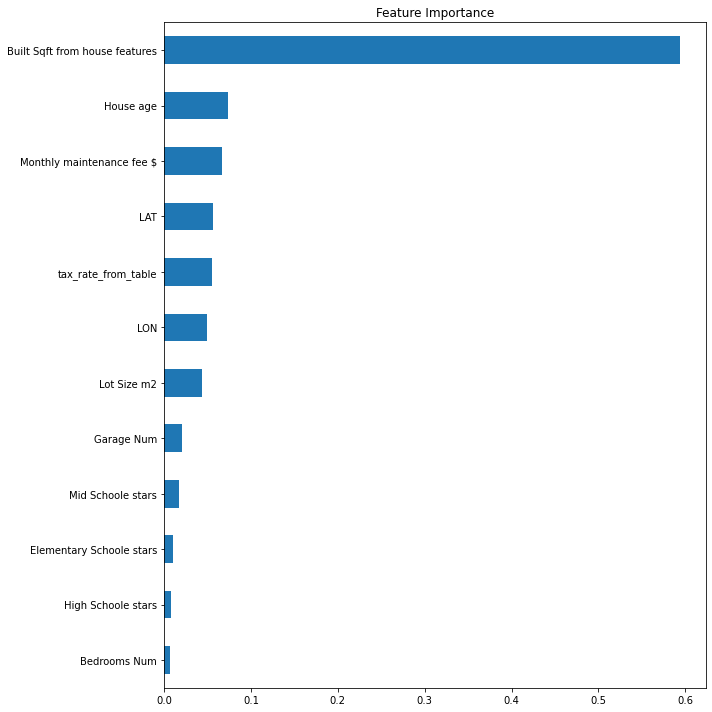

Text(0, 0.5, 'True - Predict')

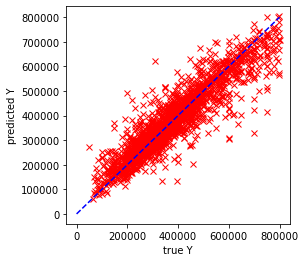

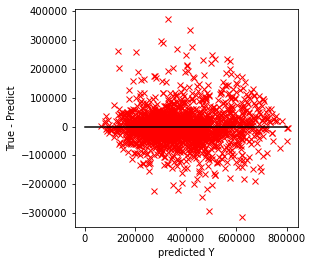

In [52]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pylab as plt



gbr_t1 = GradientBoostingRegressor(n_estimators=400, max_depth=5, learning_rate=0.08)
gbr_t1.fit(X_train, y_train)

# y_train_pred = gbr_t1.predict(X_train)
# y_test_pred = gbr_t1.predict(X_test)
print("Test score is", gbr_t1.score(X_test, y_test))
print("Train RMSE is", np.sqrt(mse(y_train, y_train_pred)))
print("Test RMSE is", np.sqrt(mse(y_test, y_test_pred)))


feat_scores = pd.DataFrame({'Feature Importance' : gbr_t1.feature_importances_},
                           index=ml_features)
feat_scores = feat_scores.sort_values(by='Feature Importance')
feat_scores.plot(kind='barh', figsize=(10, 10), legend=False, title="Feature Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(y_test, y_test_pred, "rx")
plt.plot([0, max_val], [0, max_val], 'b--')
plt.xlabel("true Y")
plt.ylabel("predicted Y")

plt.figure(figsize=(4, 4))
plt.plot(y_test_pred, y_test - y_test_pred, "rx")
plt.plot([0, max_val], [0, 0], 'k-')
plt.xlabel("predicted Y")
plt.ylabel("True - Predict")

In [53]:
feat_scores

,Feature Importance
Bedrooms Num,0.007210
High Schoole stars,0.008201
Elementary Schoole stars,0.009950
Mid Schoole stars,0.016553
Garage Num,0.020325
Lot Size m2,0.044007
LON,0.049018
tax_rate_from_table,0.054753
LAT,0.055718
Monthly maintenance fee $,0.067086


In [33]:
price_db_path = "../data/har_price_history/price_status_history.db"
get_price_history(address="3505 Hutchins Street, Houston, TX 77004", 
                  db_path=price_db_path,
)

,date,sale_rent,price,status
0,2023_04_03,sale,449000,Active
1,2023_04_04,sale,449000,Active
2,2023_04_05,sale,449000,Active
3,2023_04_06,sale,449000,Active
4,2023_04_07,sale,449000,Active
5,2023_04_08,sale,449000,Active
6,2023_04_09,sale,449000,Active


### Raw database

In [35]:
import sqlite3 
conn = sqlite3.connect(db_path)
c = conn.cursor()

In [43]:
sql_query = "select DISTINCT(address) from big_table_house_fullinfo_sale"
c.execute(sql_query)
all_addresses = [_[0] for _ in c.fetchall()]

In [44]:
len(all_addresses)

719673

In [46]:
[_ for _ in all_addresses if ("77021" in _ and "oasis" in _.lower())]

['5119 Oasis Park, Houston, TX 77021',
 '5130 Oasis Park, Houston, TX 77021',
 '5139 Oasis Park, Houston, TX 77021',
 '5142 Oasis Park, Houston, TX 77021',
 '5143 Oasis Park, Houston, TX 77021',
 '5147 Oasis Park Park, Houston, TX 77021',
 '5147 Oasis Park, Houston, TX 77021',
 '5159 Oasis Park, Houston, TX 77021',
 '5633 Oasis Palm Lane, Houston, TX 77021',
 '5637 Oasis Palm, Houston, TX 77021',
 '5653 Oasis Palm, Houston, TX 77021']

In [53]:
# get_price_history(address="5653 Oasis Palm, Houston, TX 77021", 
#                   db_path=price_db_path,
# )